In [2]:
import shutil
shutil.copy('/content/drive/My Drive/Food Dataset/dataset100.zip','/content/dataset100.zip')

'/content/dataset100.zip'

In [0]:
!unzip 'dataset100.zip'

In [0]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from tqdm import tqdm

In [0]:
def LoadFoodData(folder_path, n_cls):
  targets = []
  images = []
  boxes, labels, image_id, iscrowd = [], [], [], []
  for i in tqdm(range(1, n_cls+1)):
    info = {}
    path = os.path.join(folder_path, str(i))
    file = open(path + '/bb_info.txt')
    txt = file.read()
    file.close()
    txt = txt.split('\n')
    # Making a dict of text file
    for j in txt[1:]:
      if len(j) > 0:
        temp = j.split(' ')
        info[temp[0]] = [int(x) for x in temp[1:]]
    # For loading images and targets
    for key in info:
      target = {}
      filename = os.path.join(path, key + '.jpg')
      img = cv2.imread(filename)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      y, x = img.shape[0], img.shape[1]

      x_scalar = 224/x
      y_scalar = 224/y
      x1 = int(info[key][0]*x_scalar)
      y1 = int(info[key][1]*y_scalar)
      x2 = int(info[key][2]*x_scalar)
      y2 = int(info[key][3]*y_scalar)
      poly = [x1, y1, x2, y2]
      area = (poly[0]-poly[2]) * (poly[1]-poly[3])
      poly = torch.tensor(poly)
      poly = torch.unsqueeze(poly, 0)

      target['boxes'] = poly
      target['labels'] = torch.tensor([int(i)])
      target['image_id'] = torch.tensor([int(key)])
      target['area'] = torch.tensor([area])
      target['iscrowd'] = torch.tensor([0])

      images.append(img)
      targets.append(target)

  return images, targets

In [0]:
class FoodData(Dataset):
  def __init__(self, images, targets, transforms=None):
    self.images = images
    self.targets = targets
    self.transforms = transforms

  def __len__(self):
    return len(self.images)


  def __getitem__(self, idx):
    image = self.images[idx]
    image_copy = image
    target = self.targets[idx]
    image = torchvision.transforms.ToPILImage()(image)
    if self.transforms:
      image = self.transforms(image)
    return image_copy, image, target

def collate(batch):
  return tuple(zip(*batch))


In [7]:
images, targets = LoadFoodData('/content/UECFOOD100', 100)

train_images, test_images, train_targets, test_targets = train_test_split(images, targets, test_size = 0.2, random_state = 7)

100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


In [0]:
transform = torchvision.transforms.Compose([transforms.Resize((224,224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.5,], [0.5,])])
testdata = FoodData(test_images, test_targets, transform)
testloader = DataLoader(testdata, batch_size=1, shuffle=True, collate_fn=collate)

In [0]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 100
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
device = torch.device('cuda')
model.to(device)

model.load_state_dict(torch.load('/content/drive/My Drive/FasterRCNN/fasterrcnn_foodtracker.pth'))

<All keys matched successfully>

In [0]:
classes = ['Background']
file = open('/content/UECFOOD100/category.txt')
cls = file.read()
file.close()
cls = cls.split('\n')
for i in cls[1:]:
  if (len(i) > 0):
    temp = i.split('\t')
    classes.append(' '.join(temp[1:]))

In [0]:
def prediction_boxes(image, prediction, threshold=0.5):
  image = cv2.resize(image[0], (224,224))
  pred = prediction[0]
  boxes = pred['boxes'].data.cpu().numpy()
  labels = pred['labels'].data.cpu().numpy()
  scores = pred['scores'].data.cpu().numpy()
  for i in range(len(scores)):
    if (scores[i] >= threshold):
      box = boxes[i]
      label = labels[i]
      cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color=(255,0,i), thickness=2)
      cv2.putText(image, classes[label], (box[0], box[1]), fontFace=cv2.FONT_HERSHEY_SIMPLEX, thickness=2, fontScale=0.7, color=(255,0,i))
  plt.figure()
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image)

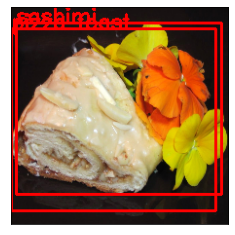

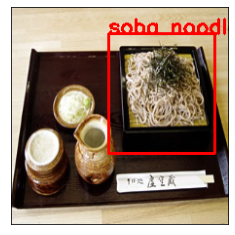

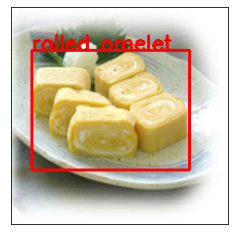

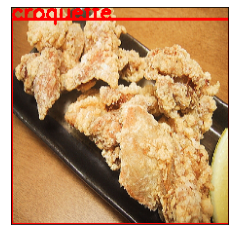

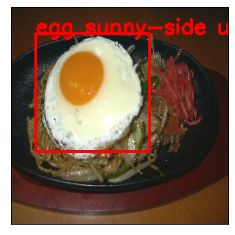

In [16]:
model.eval()
for g in range(5):
  img_, img, tar = next(iter(testloader))
  img = list(image.to(device) for image in img)
  pred = model(img)
  prediction_boxes(img_, pred)